In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random
from collections import defaultdict

import itertools

sns.set_style("whitegrid")

from IPython.display import clear_output

from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

Сгенерируем граф

In [2]:
graph = nx.generators.random_graphs.barabasi_albert_graph(72600, 10)
A = nx.convert_matrix.to_scipy_sparse_matrix(graph)

_, degrees = zip(*graph.degree())
degrees = np.asarray(degrees)
len(degrees), np.mean(degrees), sum(degrees) / 2, max(degrees)

(72600, 19.99724517906336, 725900.0, 1462)

# Cluster based randomization

[Network A/B Testing: From Sampling to Estimation](https://hanj.cs.illinois.edu/pdf/www15_hgui.pdf)

#### Label propagation

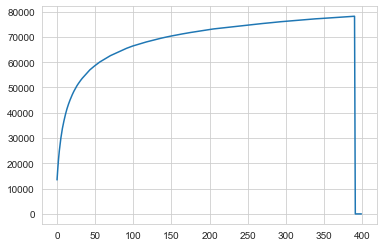

100%|██████████| 400/400 [03:42<00:00,  1.80it/s]


In [3]:
total_clusters = 100
percent_swaps = 0

iters = 400
sub_iter = 30000

current_state = np.random.randint(0, total_clusters, len(graph))
inside_cluster = np.zeros(iters)

for i in tqdm(range(iters)):
    random_vertices = random.choices(range(len(graph)), k=int(len(graph) * percent_swaps))
    random_labes = current_state[random_vertices].copy()
    np.random.shuffle(random_labes)
    current_state[random_vertices] = random_labes
    
    connections_with_c = np.zeros((len(graph), total_clusters))
    for c in range(total_clusters):
        connections_with_c[:, c] = A.dot(current_state  == c)

    random_pairs = zip(np.random.choice(len(graph), sub_iter), np.random.choice(len(graph), sub_iter))
    for a, b in random_pairs:
        a_cat = current_state[a]
        b_cat = current_state[b]

        current_value = connections_with_c[a, a_cat] + connections_with_c[b, b_cat]
        potential_value =  connections_with_c[a, b_cat] + connections_with_c[b, a_cat]

        gain = potential_value - current_value
        if gain > 0:
            current_state[a] = b_cat
            current_state[b] = a_cat

            
    for c in range(total_clusters):
        inside_cluster[i] += np.sum(A[current_state == c].dot(current_state == c)) / 2
    
    if i % 10 == 0:
        clear_output(wait=True)
        plt.plot(inside_cluster)
        plt.show()

(61.17812293456708, 10.19773077770434, 0.3249614452522582)

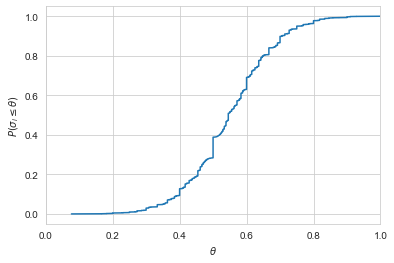

In [4]:
z_cluster = (current_state < total_clusters / 2).astype(int)

sigma_treatment = A[z_cluster > 0].dot(z_cluster > 0) / degrees[z_cluster > 0]

sorted_data = np.sort(sigma_treatment)
position = scipy.stats.rankdata(sorted_data, method='ordinal')
cdf = position / len(position)

sorted_data = np.hstack((sorted_data, 1))
cdf = np.hstack((cdf, 1))
plt.plot(sorted_data, cdf)
plt.xlabel('$\\theta$')
plt.ylabel('$P(\sigma_i \leq \\theta)$')
plt.xlim(0, 1)

(sigma_treatment > 0.5).mean() * 100, (sigma_treatment > 0.7).mean() * 100, (sigma_treatment > 0.9).mean() * 100

---
# Ego based randomization

[Using Ego-Clusters to Measure NetworkEffects at LinkedIn](https://arxiv.org/pdf/1903.08755.pdf)

In [5]:
borders = np.percentile(degrees, np.linspace(0, 100, num=10, endpoint=False), interpolation='lower')
borders = np.unique(borders)
bins = np.digitize(degrees, borders) - 1
np.unique(bins, return_counts=True)[1]

array([12154,  9245,  7304,  5839,  8643,  6092,  7591,  8122,  7610])

In [6]:
binned_nodes = defaultdict(lambda: [])
for i in range(len(graph)):
    binned_nodes[bins[i]].append(i)
binned_nodes = dict(binned_nodes)

for i in range(len(binned_nodes)):
    random.shuffle(binned_nodes[i])

upper_loss_rate = 0.2

ego_nets = {}

taken_nodes = set()

bin_id = 0
while True:
    bin = binned_nodes[bin_id]        
    while bin:
        node_id = bin.pop()
        if node_id in taken_nodes:
            continue
            
        friends = set(graph.neighbors(node_id))
        untaken_friends = list(friends - taken_nodes)
        
        if 1 - len(untaken_friends) / len(friends) > upper_loss_rate:
            continue
        random.shuffle(untaken_friends)
        k = int(np.ceil((1 - upper_loss_rate) * len(friends)))
        selected_friends = set(np.random.choice(untaken_friends, k, replace=False))

        taken_nodes.add(node_id)
        taken_nodes |= selected_friends
        ego_nets[node_id] = selected_friends
        break
        
    if not bin:
        break
    bin_id = (bin_id + 1) % len(binned_nodes)
    
len(ego_nets), len(taken_nodes)

(1259, 20499)

In [7]:
for i in set(range(len(graph))) - taken_nodes:
    potential_egos = list(set(graph.neighbors(i)) & ego_nets.keys())
    if potential_egos:
        attached_ego = random.choice(potential_egos)
        ego_nets[attached_ego].add(i)
        taken_nodes.add(i)
        
ego_lists = list(ego_nets.items())
        
len(ego_nets), len(taken_nodes)

(1259, 21417)

# Experiment

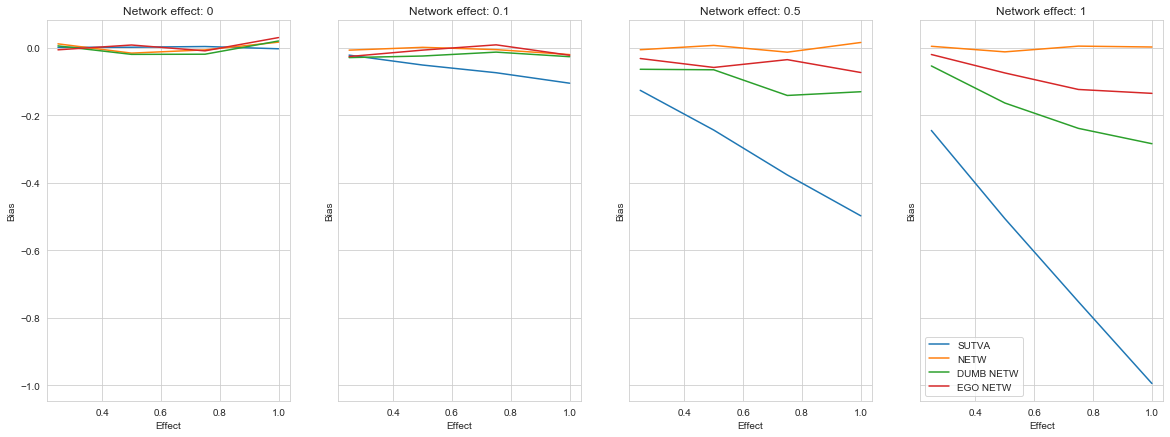

In [8]:
from sklearn.linear_model import LinearRegression as LR

def fu(z, lambda_0=-1.5, lambda_1=1, lambda_2=1, iters=2):
    y = np.zeros(len(graph))
    for _ in range(iters):
        y = lambda_0 + lambda_1 * z + lambda_2 * A.dot(y) / degrees + scipy.stats.norm().rvs(y.shape[0])
    return y

def simulate(iters=100, **kwargs):
    ate = np.zeros(iters)
    sutva = np.zeros(iters)
    netw = np.zeros(iters)
    dumb_netw = np.zeros(iters)
    ego_netw = np.zeros(iters)

    for i in range(iters):
        ate[i] = np.mean(fu(np.ones(len(graph)), **kwargs)) - np.mean(fu(np.zeros(len(graph)), **kwargs))

        z = scipy.stats.bernoulli(0.5).rvs(len(graph))
        y = fu(z, **kwargs)
        sutva[i] = np.mean(y[z > 0]) - np.mean(y[z == 0])
        #-----
        treatment_clusters = np.random.choice(total_clusters, replace=False, size=total_clusters//2)
        z_cluster = np.zeros(len(graph))
        for c in treatment_clusters:
            z_cluster[current_state == c] = 1

        n_treated = A.dot(z_cluster > 0)
        sigma_treated = n_treated / degrees
        y = fu(z_cluster, **kwargs)

        fit_0 = scipy.stats.linregress(sigma_treated[z_cluster == 0], y[z_cluster == 0])
        alpha_0 = fit_0.intercept
        gamma_0 = fit_0.slope

        fit_1 = scipy.stats.linregress(sigma_treated[z_cluster > 0], y[z_cluster > 0])
        alpha_1 = fit_1.intercept
        gamma_1 = fit_1.slope
        netw[i] = alpha_1 + gamma_1 - alpha_0
        #---
        dumb_netw[i] = np.mean(y[(z_cluster > 0) & (sigma_treated > (1 - upper_loss_rate))]) -  np.mean(y[(z_cluster == 0) & (sigma_treated < upper_loss_rate)])
        #---
        z_ego = np.zeros(len(graph))
        z_treated_egos = np.zeros(len(graph))
        z_not_treated_egos = np.zeros(len(graph))

        z_egos = scipy.stats.bernoulli(0.5).rvs(len(ego_lists))
        for j in range(len(ego_lists)):
            ego_id, alters_ids = ego_lists[j]
            if z_egos[j] > 0:
                z_treated_egos[ego_id] = 1
                z_ego[ego_id] = 1
                for alter_id in alters_ids:
                    z_ego[alter_id] = 1
            else:
                z_not_treated_egos[ego_id] = 1
        
        assert np.sum(z_treated_egos) + np.sum(z_not_treated_egos) == len(ego_nets)

        y = fu(z_ego, **kwargs)

        ego_netw[i] = np.mean(y[z_treated_egos > 0]) - np.mean(y[z_not_treated_egos > 0])

    return ate, sutva, netw, dumb_netw, ego_netw

lambda_1s = [0.25, 0.5, 0.75, 1]
lambda_2s = [0, 0.1, 0.5, 1]

biases_sutva = np.zeros((len(lambda_1s), len(lambda_2s)))
biases_netw = biases_sutva.copy()
biases_dumb_netw = biases_sutva.copy()
biases_ego_netw = biases_sutva.copy()

for i in range(len(lambda_1s)):
    for j in range(len(lambda_2s)):            
        ate, sutva, netw, dumb_netw, ego_netw = simulate(iters=10, lambda_1=lambda_1s[i], lambda_2=lambda_2s[j])
        biases_sutva[i, j] = np.mean(sutva - ate)
        biases_netw[i, j] = np.mean(netw - ate)
        biases_dumb_netw[i, j] = np.mean(dumb_netw - ate)
        biases_ego_netw[i, j] = np.mean(ego_netw - ate)    

fig, axes = plt.subplots(1, len(lambda_2s), sharey=True, figsize=(20, 7))

for j, ax in enumerate(axes):
    ax.plot(lambda_1s, biases_sutva[:, j], label='SUTVA')
    ax.plot(lambda_1s, biases_netw[:, j], label='NETW')
    ax.plot(lambda_1s, biases_dumb_netw[:, j], label='DUMB NETW')
    ax.plot(lambda_1s, biases_ego_netw[:, j], label='EGO NETW')

    ax.set_title(f'Network effect: {lambda_2s[j]}')
    ax.set_ylabel('Bias')
    ax.set_xlabel('Effect')
    
plt.legend()

In [9]:
ate, sutva, netw, dumb_netw, biases_ego_netw = simulate(iters=100, lambda_1=1, lambda_2=0)
(np.std(netw) / np.std(sutva)) ** 2, (np.std(dumb_netw) / np.std(sutva)) ** 2, (np.std(biases_ego_netw) / np.std(sutva)) ** 2

(11.519292480187785, 40.62033500430788, 44.74240740004394)

---
# Edge based analysis

[A Method for Measuring Network Effects ofOne-to-One Communication Features inOnline A/B Tests](https://arxiv.org/pdf/1903.08766.pdf)

---
# Common resources

[Fairness through Experimentation: Inequality in A/B testing as an approach to responsible design](https://arxiv.org/abs/2002.05819)